In [157]:
import numpy as np


def check_type(func):
        def element_check_and_operate(*args, **kwargs):
            elements = [isinstance(arg, Element) for arg in args] #figure out which of the arguments are elements
            args = [args[i] if val else Element(args[i],name= 'num', track_grad = False) for i, val in enumerate(elements)]
            values = tuple([args[i].value for i in range(len(args))]) #get the values of each argument
            #print(values)
            #print([i for i, val in enumerate(elements) if val])
            out = Element(func(*values, **kwargs), args, func.__name__) #create element with the output value of function and correct parents and creator function
            #print(out.parents)
            return out
        return element_check_and_operate
    
class Element(object):
    """A class representing an element of the computation graph
       with value."""
    
    
    def __init__(self, value, parents=None, function='NA', name = '', track_grad = True):
        self.value = value
        self.parents = parents
        self.function = function
        self.grad = 0
        self.name = name
        self.track_grad = track_grad
       
    @check_type
    def __add__(self, x):
        return self+x
        
    @check_type        
    def __mul__(self, x):
        return self*x
    @check_type
    def __rmul__(self,x):
        return self*x
    
    @check_type
    def __truediv__(self,x):
        return self/x
    
    @check_type
    def __sub__(self, x):
        return self-x
    
    @check_type
    def __pow__(self,x):
        return self ** x
    
    def __str__(self):
        return str(self.value)
    
@check_type    
def log(num, base):
    assert base is not 1
    return (np.log(num)/np.log(base))

@check_type
def sin(theta):
    return np.sin(theta)

@check_type
def cos(theta):
    return np.cos(theta)

@check_type
def tan(theta):
    return np.tan(theta)

    

def backprop(e : Element, grad = Element(1)):
    e.grad = (grad + e.grad) if isinstance(e.grad, Element) else grad
    e.grad.name = grad.name
    
    f_name = e.function if e.function is not None else None
    if e.parents is not None:
        for i, p in enumerate(e.parents):
            if p.track_grad:
                if f_name == '__add__':
                    #backprop(p, grad = e.grad)
                    parent_grad = e.grad
                elif f_name == '__mul__' or f_name =='__rmul__':
                    #backprop(p, grad = e.grad*(e.parents[1-i]))
                    parent_grad = e.grad*(e.parents[1-i])
                elif f_name == '__sub__':
                    if i == 0:
                        #backprop(p, grad = e.grad)
                        parent_grad = e.grad
                    else:
                        #backprop(p, grad = e.grad*(-1))
                        parent_grad = e.grad*(-1)
                elif f_name == '__truediv__':
                    if i == 0:
                        #backprop(p, grad = e.grad*(Element(1,None, None)/e.parents[1]))
                        parent_grad = e.grad*(Element(1)/e.parents[1])
                    else:
                        #backprop(p, grad = e.grad*(-1)*e.parents[0]*p**-2)
                        parent_grad = e.grad*(-1)*e.parents[0]*p**-2
                elif f_name == '__pow__':
                    if i == 0:
                        #backprop(p, grad = e.grad*(e.parents[1])*p**(e.parents[1]-1))
                        parent_grad = e.grad*(e.parents[1])*p**(e.parents[1]-1)
                    else:
                        #backprop(p, grad = e.grad*0)
                        parent_grad = e.grad*(e.parents[0]**p)*log(e.parents[0],np.e)

                elif f_name == 'log':
                    if i == 0:
                        parent_grad = e.grad*(Element(1)/p)*log(e.parents[1],np.e)
                    else:
                        parent_grad = e.grad*(-1)*(log(e.parents[0],np.e)/(p*np.log(p,np.e)**2))
                        
                elif f_name == 'sin':
                    parent_grad = e.grad*(cos(p))
                elif f_name == 'cos':
                    parent_grad = e.grad*(sin(p)*(-1))
                elif f_name == 'tan':
                    parent_grad = e.grad*(Element(1)/(cos(p)**2))

                parent_grad.name = p.name+'grad'
                backprop(p, grad = parent_grad)

                
def traceback(e : Element, first = True):
    
    l = [0,[]]
    l[0] = (e.name, e.value, e.grad.value if isinstance(e.grad, Element) else e.grad, e.function)
    if e.parents is not None:
        for parent in e.parents:
            t = traceback(parent, first = False)
            l[1].append(t[0])
            l[1].append(t[1])
    
    
    return l
            
def graph_print(l, name = False, value = True, grad = False, function = True):
    
    while True:
        isList = [isinstance(l[i], list) for i in range(len(l))]
        if False in isList:
            idxs = [i for i, val in enumerate(isList) if not val]
            idxs.reverse()
            to_print = []
            for i in idxs:
                info = l.pop(i)    
                to_print.append((('n: %6s ' % info[0]) if name else '') + 
                                (('val: %5.3f ' %info[1]) if value else '') + 
                                (('g: %5.3f ' %info[2]) if grad else '')+ 
                                (('fun: %4s' % info[3].replace('_','')) if function else ''))
            to_print.reverse()
            print(to_print)

        elif l == []:
            break
        else:
            t = []
            for i in range(len(l)):
                for j in range(len(l[i])):
                    t.append(l[i][j])
            l = t
                
def flush_grads(e: Element):
    e.grad = 0
    if e.parents is not None:
        for parent in e.parents:
            flush_grads(parent)

In [164]:
def fun3(x):
    return x**x
x = Element(3,name='x')
y = fun3(x)
y.name = 'x'
flush_grads(y)
backprop(y)
graph_print(traceback(y),grad = True,name=True)
print(x.grad)

['n:      x val: 27.000 g: 1.000 fun:  pow']
['n:      x val: 3.000 g: 56.663 fun:   NA', 'n:      x val: 3.000 g: 56.663 fun:   NA']
56.66253179403897


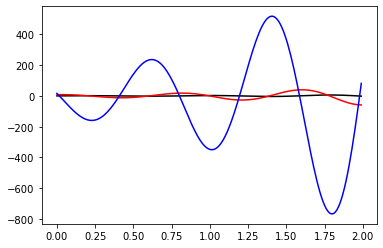

In [174]:
#To test the deriv, you can change the testfunc


import matplotlib.pyplot as plt

def testfunc(x):
    #x = Element(x)
    return Element(np.e)**(x) * sin(x*8)

def getxgrad(x):
    x = Element(x)
    backprop(testfunc(x))
    return x

def gethighergrad(x, order = 2):
    x = Element(x)
    backprop(testfunc(x))
    for i in range(order-1):
        y = x.grad
        flush_grads(y)
        backprop(y)
    return x.grad.value

range_lower = 0
range_upper = 2
step = 100

range_tuple = (int(range_lower*step),int(range_upper*step))

plt.plot([i/step for i in range(*range_tuple)],[(testfunc(Element(x/step)).value) for x in range(*range_tuple)], 'black')
grads = [(getxgrad(x/step).grad.value) for x in range(*range_tuple)]
plt.plot([i/step for i in range(*range_tuple)],grads, 'red')

grads_2 = [(gethighergrad(x/step,2)) for x in range(*range_tuple)]
plt.plot([i/step for i in range(*range_tuple)],grads_2, 'blue')

plt.show()